In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [2]:
def shade_currency(currencies, size_train, name_predictColumn):
    currencies = currencies
    currency_target = currencies[0]

    # Set the date range
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=15*365)).strftime('%Y-%m-%d')

    # Create an Empty DataFrame to Store the Data
    currency_data= pd.DataFrame()

    # Loop for Each Currency Pair
    for currency in currencies:
        data = yf.download(currency, start=start_date, end=end_date)
        currency_data[currency] = data['Close']
        
    ## Data Cleaning
    currency_data.dropna(inplace=True)
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(currency_data.drop(columns=[currency_target]))
    
    ## Perfoming PCA

    # Perform PCA
    pca = PCA(n_components=2) # You can change the number of components if needed
    principal_components = pca.fit_transform(scaled_data)

    # Create DF with the PCA
    principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    
    ## Statistics Model

    # Define the target variable (HUF)
    target = currency_data[currency_target]
    target = target.reset_index(drop=True)

    # Combine the principal components and the target variable
    combined_data = pd.concat([principal_df, target], axis=1)

    # Split the data into training and test sets
    train_size = int(len(combined_data) * size_train)
    train, test = combined_data[:train_size], combined_data[train_size:]
    
    # Fit the ARIMA model on the training data
    model = ARIMA(train[currency_target], exog=train[['PC1', 'PC2']], order=(0, 0, 0))
    model_fit = model.fit()

    # Forecast on the test data
    forecast = model_fit.forecast(steps=len(test), exog=test[['PC1', 'PC2']])

    # Compare the forecast with the actual values
    test['Forecast'] = forecast
    df_results = test[[currency_target, 'Forecast']]
    
    # Indexing to Dates
    df_results.index = currency_data[train_size:].index
    
    # Rename the column
    df_results = df_results.rename(columns={'Forecast': name_predictColumn})
    
    return df_results

In [16]:
currencies_commodities = ['BRL=X', 'ZAR=X', 'ARS=X', 'CLP=X', 'COP=X', 'PEN=X', 'AUD=X', 'NZD=X']
currencies_emergentes = ['BRL=X', 'ZAR=X', 'ARS=X', 'CLP=X', 'COP=X', 'PEN=X', 'TRY=X', 'MXN=X','PLN=X','HUF=X']

df_emergentes = shade_currency(currencies_emergentes, 0.97, 'emergentes')
df_commodities = shade_currency(currencies_commodities, 0.97, 'commodities')

# Example of merging on 'Date' column
merged_df = pd.merge(df_emergentes, df_commodities, on=['Date','BRL=X'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_2215/3507737868.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

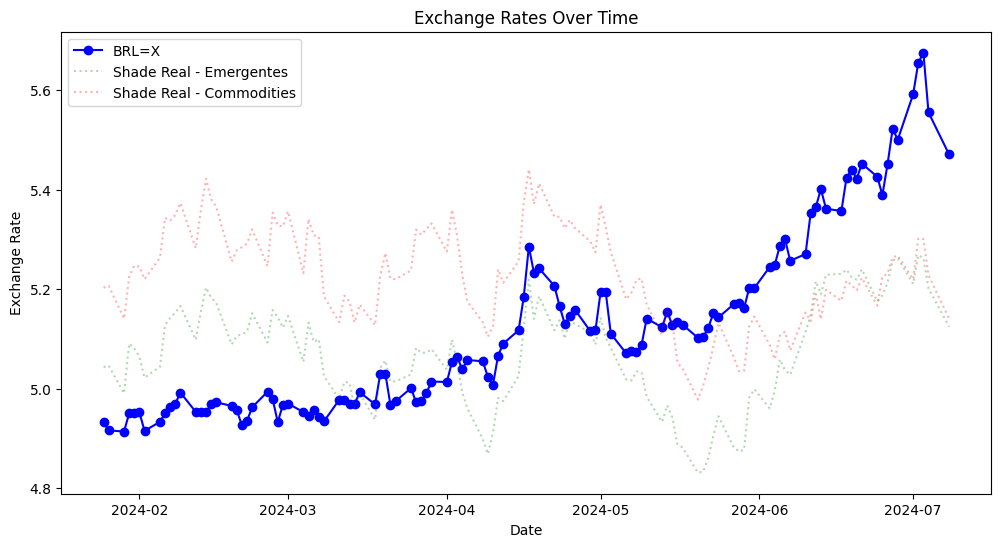

In [25]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot BRL=X with default thicker line
plt.plot(merged_df.index, merged_df['BRL=X'], label='BRL=X', color='blue', marker='o')

# Plot emergentes with thinner line and circle markers
plt.plot(merged_df.index, merged_df['emergentes'], label='Shade Real - Emergentes', color='green', linestyle=':', alpha=0.3)

# Plot commodities with thinner line and triangle markers
plt.plot(merged_df.index, merged_df['commodities'], label='Shade Real - Commodities', color='red', linestyle=':', alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rates Over Time')
plt.legend()


In [ ]:
import numpy as np

# Assuming df_results contains 'BRL=X' (actual) and 'Forecast' (forecasted) columns

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(df_results['BRL=X'] - df_results['Forecast']))

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((df_results['BRL=X'] - df_results['Forecast']) / df_results['BRL=X'])) * 100

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((df_results['BRL=X'] - df_results['Forecast']) ** 2))

# R-squared (Coefficient of Determination)
actual_mean = np.mean(df_results['BRL=X'])
ss_res = np.sum((df_results['BRL=X'] - df_results['Forecast']) ** 2)
ss_tot = np.sum((df_results['BRL=X'] - actual_mean) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (Coefficient of Determination): {r_squared}")

Mean Absolute Error (MAE): 0.1476572570518099
Mean Absolute Percentage Error (MAPE): 2.8522668017013344
Root Mean Squared Error (RMSE): 0.17501705336767578
R-squared (Coefficient of Determination): 0.08455230841295969
